###Setting up the environment and install packages

In [ ]:
#pip install earthengine-api --upgrade

import subprocess
try:
  import geemap
except ImportError:
  print('geemap package not installed. Installing ...')
  subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])
  import geemap
try:
  import geetools
except ImportError:
  print('geetools package not installed. Installing ...')
  subprocess.check_call(["python", '-m', 'pip', 'install', 'geetools'])
  import geetools

import ee
try:
  ee.Initialize()
except Exception as e:
  ee.Authenticate()
  ee.Initialize()

Map = geemap.Map()

### ***Set Up Input parameters (AOI, Time Range, Number of Samples)


In [ ]:
# Specify area of interest (change path to the GEE asset); This input polygon should capture most areas of the reservoir
aoi = ee.FeatureCollection('projects/ee-climatechangehydrology/assets/test_aoi')
buffer_size = 250

# Create a buffer
aoi_buff = (aoi.geometry()).buffer(buffer_size)
aoi_buff = ee.Feature(aoi_buff)

# Set up a function to clip the images within the aoi buffer zone
def clip_to_aoi_buff(imagecollection):
  return imagecollection.clip(aoi_buff)

# **** A buffer is needed three major reasons:
#1. Reduce the size of the image collection for intermediate processsing;
#2. Controls the training samples to be within a specified distance;
#3. Clipping the final outcomes for export

# Number of training points
numWaterPts = 250
numLandPts = 250

######  Specify filter dates for the Sentinel-1 images ###########
Yr2015 =  ee.Filter.date('2015-06-01', '2015-09-01')
Yr2016 =  ee.Filter.date('2016-06-01', '2016-09-01')
Yr2017 =  ee.Filter.date('2017-06-01', '2017-09-01')
Yr2018 =  ee.Filter.date('2018-06-01', '2018-09-01')
Yr2019 =  ee.Filter.date('2019-06-01', '2019-09-01')
Yr2020 =  ee.Filter.date('2020-06-01', '2020-09-01')
Yr2021 =  ee.Filter.date('2021-06-01', '2021-09-01')
Yr2022 =  ee.Filter.date('2022-06-01', '2022-09-01')

# Combine these dates to create a single time filter
TimeFilter = ee.Filter.Or(Yr2015, Yr2016, Yr2017,Yr2018,Yr2019,Yr2020,Yr2021,Yr2022)
#TimeFilter = ee.Filter.Or(Yr2017)

###Specify where you want to export the data to

In [ ]:
# What's the Name of the reservoir?
res_name = 'ArnPrior'

# Name of the folder you want to export to on Google Drive (a new one will be created if none exists)
FolderName = 'HydroReservoir_Data'

# Path of your GEE directory where you want to export the data as an Google Asset
GEE_AssetDirectory = 'projects/ee-climatechangehydrology/assets/'

# Give a readable name for your export task (this will be shown on GEE's task manager)
TaskDescription_Probability = str(res_name)+'_ProbailityMap'

### Create a SAR Image Stack

In [ ]:
s1_stack = ee.ImageCollection('COPERNICUS/S1_GRD')  \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW'))  \
    .filter(TimeFilter)\
    .filterBounds(aoi)\
    .filterMetadata('orbitProperties_pass', 'equals', 'ASCENDING')\
    .map(clip_to_aoi_buff)\

# Change the image values to float type
s1_stack = s1_stack.map(lambda image: image.toFloat())

#Get Track Numbers of the Images (more tracks = increase complexity)
track_num = s1_stack.aggregate_array('relativeOrbitNumber_start')
#track_num.distinct()

### Filter Image Stack with the Most Frequent Orbital Track (avoid using data from multiple tracks for training samples)

In [ ]:
# Get the most common orbital track from the initial image stack (best track to use for training the model)
best_track = track_num.reduce(ee.Reducer.mode())
best_track = ee.Number(best_track)

# Filter the image stack to include images only for this track
s1_stack = s1_stack.filterMetadata('relativeOrbitNumber_start', 'equals', best_track)

###Save the Original Image Properties

In [ ]:
# Save all the image properties as a list so that the final images can have metadata appended.
# This step is needed because metadata will be removed after the LEE filter is applied

savedSystemIndexList = s1_stack.aggregate_array('system:index')
savedOrbitPropertiesPassList = s1_stack.aggregate_array('orbitProperties_pass')
savedRelativeOrbitStartList = s1_stack.aggregate_array('relativeOrbitNumber_start')
savedTimeStartList = s1_stack.aggregate_array('system:time_start')

### Set Up the Refined Lee Filter and Apply the Filter to the "VV" and "VH" Bands using a 7x7 Kernel

In [ ]:
# @title Set Up a 7x7 Refined LEE Filter
# Source: https://mygeoblog.com/2018/02/16/timeseries-with-sar/

# Convert image from db to natural units:
toNatural = lambda img: ee.Image(10.0).pow(img.select(0).divide(10.0))

# After running the filter, convert the natural units back to dB
toDB = lambda img: ee.Image(img).log10().multiply(10.0)

def RefinedLee(img):
  # img must be in natural units, i.e. not in dB!
  # Set up a 7x7 kernel
  myimg = toNatural(img)
  weights7 = ee.List.repeat(ee.List.repeat(1,7),7)
  kernel7 = ee.Kernel.fixed(7,7, weights7, 1, 1, False)
  mean7 = myimg.reduceNeighborhood(ee.Reducer.mean(), kernel7)
  variance7 = myimg.reduceNeighborhood(ee.Reducer.variance(), kernel7)

  # Use a sample of the 7x7 windows inside a 15x15 windows to determine gradients and directions
  sample_weights = ee.List([
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  ])
  sample_kernel = ee.Kernel.fixed(15,15, sample_weights, 7,7, False)

  # Calculate mean and variance for the sampled windows and store as 9 bands
  sample_mean = mean7.neighborhoodToBands(sample_kernel)
  sample_var = variance7.neighborhoodToBands(sample_kernel)

  # Determine the 4 gradients for the sampled windows
  gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs()
  gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs())
  gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs())
  gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs())

  # And find the maximum gradient amongst gradient bands
  max_gradient = gradients.reduce(ee.Reducer.max())

  # Create a mask for band pixels that are the maximum gradient
  gradmask = gradients.eq(max_gradient)

  # duplicate gradmask bands: each gradient represents 2 directions
  gradmask = gradmask.addBands(gradmask)

  # Determine the 8 directions
  directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1)
  directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2))
  directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3))
  directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4))
  # The next 4 are the not() of the previous 4
  directions = directions.addBands(directions.select(0).Not().multiply(5))
  directions = directions.addBands(directions.select(1).Not().multiply(6))
  directions = directions.addBands(directions.select(2).Not().multiply(7))
  directions = directions.addBands(directions.select(3).Not().multiply(8))

  # Mask all values that are not 1-8
  directions = directions.updateMask(gradmask)

  # "collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
  directions = directions.reduce(ee.Reducer.sum())
  sample_stats = sample_var.divide(sample_mean.multiply(sample_mean))

  # Calculate localNoiseVariance
  sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0])

  # Set up the 15*15 kernels for directional statistics
  rect_weights = ee.List.repeat(ee.List.repeat(0,15),7).cat(ee.List.repeat(ee.List.repeat(1,15),8))

  diag_weights = ee.List([
      [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
      [1,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
      [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0],
      [1,1,1,1,1,0,0,0,0,0,0,0,0,0,0],
      [1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],
      [1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
      [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0],
      [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
      [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0],
      [1,1,1,1,1,1,1,1,1,1,1,0,0,0,0],
      [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0],
      [1,1,1,1,1,1,1,1,1,1,1,1,1,0,0],
      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
  ])

  rect_kernel = ee.Kernel.fixed(15,15, rect_weights, 7, 7, False)
  diag_kernel = ee.Kernel.fixed(15,15, diag_weights, 7, 7, False)

  # Create stacks for mean and variance using the original kernels. Mask with relevant direction.
  dir_mean = myimg.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1))
  dir_var = myimg.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1))

  dir_mean = dir_mean.addBands(myimg.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(directions.eq(2)))
  dir_var = dir_var.addBands(myimg.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(directions.eq(2)))

  # and add the bands for rotated kernels
  for i in range(1, 8):
    dir_mean = dir_mean.addBands(myimg.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
    dir_var = dir_var.addBands(myimg.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
    dir_mean = dir_mean.addBands(myimg.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
    dir_var = dir_var.addBands(myimg.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))

  # "collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
  dir_mean = dir_mean.reduce(ee.Reducer.sum())
  dir_var = dir_var.reduce(ee.Reducer.sum())

  # A finally generate the filtered value
  varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))
  b = varX.divide(dir_var)
  result = dir_mean.add(b.multiply(myimg.subtract(dir_mean)))
  return ee.Image(toDB(result.arrayGet(0))).toFloat()

In [ ]:
# @title Apply the LEE Filter to VV and VH

# The bands for VV and VH are both named 'sum' after the Lee filter is applied, and are renamed back to VV and VH afterwards
s1_LeeVV = s1_stack.select('VV').map(RefinedLee).select(['sum'], ['VV'])
s1_LeeVH = s1_stack.select('VH').map(RefinedLee).select(['sum'], ['VH'])

# Save the angle band and a dummy collection with no bands
s1_angle = s1_stack.select(['angle'])
dummy = s1_stack.select([])

# Creating the filter for the joins
filter = ee.Filter.equals(leftField = 'system:index', rightField = 'system:index')

# Create the simple join
simpleJoin = ee.Join.inner();

# Function used with the inner joins
doFeaturePrimarySecondary = lambda feature: ee.Image.cat(feature.get('primary'), feature.get('secondary'))

# Create the inner join for merging the VV and VH collections
# Join the VV and VH into a single image collection
innerJoin = ee.ImageCollection(simpleJoin.apply(s1_LeeVV, s1_LeeVH, filter))
s1_VV_VH = innerJoin.map(doFeaturePrimarySecondary)

# Create the inner join for merging the angle and dummy collections
# Join angle and dummy into a single image collection
innerJoin2 = ee.ImageCollection(simpleJoin.apply(s1_angle, dummy, filter))
s1_angle_dummy = innerJoin2.map(doFeaturePrimarySecondary)

# Create the inner join for merging the angle and dummy collections
# Join VV_VH and angle_dummy into a single image collection
innerJoin3 = ee.ImageCollection(simpleJoin.apply(s1_VV_VH, s1_angle_dummy, filter))
s1_stack = innerJoin3.map(doFeaturePrimarySecondary)

###Calculate Standard Deviation and GLCM using a 7x7 Kernel

In [ ]:
####### Standard Deviation #################
def compute_VV_stdDev(image):
    VV_stdDev = image.select('VV').reduceNeighborhood(reducer = ee.Reducer.stdDev(), kernel = ee.Kernel.square(7))
    return image.addBands(VV_stdDev)
s1_stack = s1_stack.map(compute_VV_stdDev)

def compute_VH_stdDev(image):
    VH_stdDev = image.select('VH').reduceNeighborhood(reducer = ee.Reducer.stdDev(), kernel = ee.Kernel.square(7))
    return image.addBands(VH_stdDev)
s1_stack = s1_stack.map(compute_VH_stdDev)

####### GLCM bands #################
glcm_bands = ['VH_asm', 'VH_contrast', 'VH_corr', 'VH_idm']
def addGLCM(image):
  img16 = ee.Image(image).toInt16()# Ensures variables are stored in 16-bit integers
  glcm = img16.glcmTexture(size = 7).select(glcm_bands).toFloat()
  return image.addBands(glcm)

s1_stack = s1_stack.map(addGLCM)

### Add Properities Back to the Filtered Stack

In [ ]:
# Make a list of index values and turn the image collection into a list
indexList = ee.List.sequence(0, s1_stack.size().subtract(1))
listOfImages = s1_stack.toList(s1_stack.size())

# Function for adding the properties back to the images
def addProperties(index):
  # Get the image at the index
  image = ee.Image(listOfImages.get(index))
  # Get the properties from the saved lists based on the index
  systemIndex = savedSystemIndexList.get(index)
  orbitPropertiesPass = savedOrbitPropertiesPassList.get(index)
  relativeOrbitStart = savedRelativeOrbitStartList.get(index)
  timeStart = savedTimeStartList.get(index)

  # Change the properties to the format that is needed for the exported image name and add them back to the image
  image = image.set('savedSystemIndex', ee.String(systemIndex).slice(0, 32))
  image = image.set('savedOrbitPropertiesPass', ee.String(orbitPropertiesPass).slice(0, 3))
  image = image.set('savedRelativeOrbitStart', (ee.Number(relativeOrbitStart).toByte()).format())
  image = image.set('system:time_start', ee.Number(timeStart))
  return image

# Now all properties are returned to the images
s1_stack_finalized = ee.ImageCollection(indexList.map(addProperties))

# Check if all the bands are added to the stack
#stack_finalized_json = s1_stack_finalized.getInfo()
#stacked_img_json = getImageFromCollection(stack_finalized_json)
#printImageBands(stacked_img_json)

### Mosaic Adjacent Images and Remove Duplicates

In [ ]:
###### Mosaic adjacent images that were taken on the same day ###########
# Source: https://gis.stackexchange.com/questions/369057/google-earth-engine-roi-area-falling-outside-partial-coverage-by-sentinel-1-tile/370455#370455

def makeMosaics(image):
  thisImage = ee.Image(image)
  date = ee.Date(thisImage.get('system:time_start'))
  orbitPropertiesPass = thisImage.get('savedOrbitPropertiesPass')
  filtered_stack = s1_stack_finalized  \
    .filterDate(date, date.advance(1,'day'))  \
    .filter(ee.Filter.eq('savedOrbitPropertiesPass', orbitPropertiesPass))
  # Mosaic the filtered images together and copy the metadata/image properties
  return ee.Image(filtered_stack.mosaic().copyProperties(image, ['system:time_start', 'savedSystemIndex', 'savedOrbitPropertiesPass', 'savedRelativeOrbitStart']))

s1_stack_mosaic = s1_stack_finalized.map(makeMosaics)

###### Remove images that were acquired but processed at different dates (a Sentinel-1 problem)###########
# Source: https://gis.stackexchange.com/questions/336257/filter-out-duplicate-sentinel-2-images-form-earth-engine-image-collection-by-dat

# Generate a list from the mosaiced images
compareDateListOriginal = s1_stack_mosaic.toList(s1_stack_mosaic.size())
# Create an list with a dummy image with a dummy date
startList = ee.List([ee.Image().set('system:time_start', ee.Date(0))])
# Add the dummy list to the beginning of the mosaiced list
compareDateList = startList.cat(compareDateListOriginal)

# Function to find all the duplicates
def findDuplicates(image):
  # Index of the image in the list
  index = compareDateList.indexOf(image)
  # Get the previous image in the list
  prevImage = ee.Image(compareDateList.get(index.subtract(1)))
  # Compare date of the image with the date of the previous image in the list
  date1 = ee.Date(image.get('system:time_start')).format('Y-M-d')
  date2 = ee.Date(prevImage.get('system:time_start')).format('Y-M-d')
  duplicateCheck = ee.Algorithms.IsEqual(date1, date2)
  # String reprisenting if image is a duplicate or not
  isDuplicate = ee.String('')
  # Set the string
  isDuplicate = ee.String(ee.Algorithms.If(condition = duplicateCheck, trueCase = 'duplicate', falseCase = 'no duplicate'))
  return image.set('duplicate', isDuplicate)

# Find all the duplicates and then filter to remove them
s1_stack_check = s1_stack_mosaic.map(findDuplicates)
s1_stack_no_duplicates = s1_stack_check.filter(ee.Filter.eq('duplicate', 'no duplicate'))

# Get info on the number of images on the image stack after mosaic and removing duplicates:
num_images = s1_stack_no_duplicates.size()
#num_images

### Create an "ID" field for the Image Stack

In [ ]:
# Without the ID field, the script can run into issues
# Make a list of id values the size of s1_stack (mosaic, no duplicates)
list_of_ids = ee.List.sequence(0, s1_stack_no_duplicates.size().subtract(1))
# Turn s1_stack into a list
stack_list = s1_stack_no_duplicates.toList(s1_stack_no_duplicates.size())

# Function for adding the index value as the property ID (unique id# = system index#)
def addID(index):
  image = ee.Image(stack_list.get(index))
  indexNum = ee.Number(index)
  image = image.set('ID', indexNum)
  return image
s1_stack = ee.ImageCollection(list_of_ids.map(addID))

###Get Permanent Water and Land Areas from Dynamic World

In [ ]:
#Import the water layer from "Dynamic World"
#Create a composite with values of average probability for water

dw_water = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')\
    .filter(TimeFilter)\
    .filterBounds(aoi)\
    .map(clip_to_aoi_buff)\
    .mean()\
    .select('water').rename('class')

# Set a <5% threshold to get permanent land areas, set land = 0
perm_land = dw_water.lt(0.05)
perm_land = perm_land.selfMask()
perm_land = perm_land.where(perm_land.eq(1), 0)
perm_land = perm_land.toInt()

# Set a >50% threshold to get permanent water areas
perm_water = dw_water.gt(0.50)
perm_water = perm_water.selfMask()
perm_water = perm_water.toInt()

# Now label is renamed as "class", where water = 1 and land = 0

### Set Up Functions to Create Training Points and Obtain Training Data

In [ ]:
# Define the geometry for where samples are contained
# Using the filtered s1_stack (1 orbital track), we want to limit the samples within the image extent instead of 'aoi_buff'

def settingGeometry(f):
  return f.setGeometry(ee.Geometry.Point([f.get('longitude'), f.get('latitude')]))

# Obtain water samples
def getWaterPoints(points, seedValue, imgGeo):
  waterPts = perm_water.addBands(ee.Image.pixelLonLat())\
    .stratifiedSample(
      numPoints = points,
      classBand = 'class',
      projection = 'EPSG:4326',
      scale = 10,
      region = imgGeo,
      seed = seedValue
    ).map(settingGeometry)
  return waterPts

# Obtain land samples
def getLandPoints(points, seedValue, imgGeo):
  landPts = perm_land.addBands(ee.Image.pixelLonLat())\
    .stratifiedSample(
      numPoints = points,
      classBand = 'class',
      projection = 'EPSG:4326',
      scale = 10,
      region = imgGeo,
      seed = seedValue
    ).map(settingGeometry)
  return landPts

# Extract predictor data from the image stack using the water and land samples
def extractTraining(image):
  imageGeometry = aoi_buff.geometry()
  ID = image.get('ID')
  WaterPts = getWaterPoints(numWaterPts, ID, imageGeometry)
  LandPts = getLandPoints(numLandPts, ID, imageGeometry)
  PtsMerged = LandPts.merge(WaterPts)

  # Add the "Pass" & "Track" columns to the point features
  def addPass(feature):
    return ee.Feature(feature.set('pass', image.get('savedOrbitPropertiesPass')))
  PtsMergedWithPass = PtsMerged.map(addPass)
  def addTrack(feature):
    return ee.Feature(feature.set('track', image.get('savedRelativeOrbitStart')))
  PtsMergedWithPassAndTrack = PtsMergedWithPass.map(addTrack)

  # Train the points for the image
  trainingData = image.select(bands).sampleRegions(collection = PtsMergedWithPassAndTrack, properties = [label, 'pass', 'track'], scale = 10, geometries = True, tileScale = 2)
  return trainingData

### Initial Sampling and Get Training Data

In [ ]:
# Getting all the band names
bands = s1_stack.first().bandNames()

# The land cover info are stored in the 'class' column (1 = water, 0= land)
label = 'class'
training_data = s1_stack.map(extractTraining).flatten()

### Create a Random Forest Classifier

In [ ]:
# Specify predictor data bands
bands_of_interest = ['VV', 'VH', 'angle', 'VV_stdDev','VH_stdDev','VH_asm', 'VH_contrast', 'VH_corr', 'VH_idm']

# Create a random forest classifier with 500 trees
ee_classifier = ee.Classifier.smileRandomForest(500).setOutputMode('RAW').train(training_data, label, bands_of_interest)

### Run the Classifier on the Image Collection

In [ ]:
## Set up a function to run the rf classifier for every image in the image collection
def classification(image):
  classified = image.select(bands_of_interest).classify(ee_classifier)
  prob = classified.arrayReduce(ee.Reducer.mean(), ee.List([0])).arrayGet(0)
  return prob

# Apply the RF model to the image collection
classified_result = s1_stack.map(classification)

### Get the Average Probability Raster ###
SAR_WaterProbability = classified_result.mean()

###Get Max and Min Water Polygons (Data Classification)

In [ ]:
import numpy as np
# Do a natural breaks classification with three classes (non-water,seasonal water, permanent water)
histogram = SAR_WaterProbability.reduceRegion(reducer=ee.Reducer.histogram(),geometry=aoi_buff.geometry(),scale=10)

# Extract the histogram values
histogram_values = histogram.get('classification')  #Change the band name if needed
# Convert histogram values to a list
histogram_dict = ee.Dictionary(histogram_values)
#Extract the "buketMeans" from the dictionary
means_arrays = histogram_dict.get('bucketMeans')
#Convert the array into a python list and then a numpy array
np_array = np.array(means_arrays.getInfo())

#Get the break values for the 3 classes
values_array = np.histogram(np_array, bins=3)[1]

In [ ]:
# Non-water = <=array[1]
# seasonal water >array[1] but <=array [2]
# Permanent water > array [2] but <=array[3]

max_water = SAR_WaterProbability.gt(values_array[1]).selfMask()
min_water = SAR_WaterProbability.gt(values_array[2]).selfMask()

#Convert to vectors
max_water_poly = max_water.reduceToVectors(geometryType='polygon', geometry = aoi_buff.geometry(),scale=10, eightConnected=False, labelProperty='b1',bestEffort=True)
min_water_poly = min_water.reduceToVectors(geometryType='polygon', geometry = aoi_buff.geometry(),scale=10, eightConnected=False, labelProperty='b1',bestEffort=True)

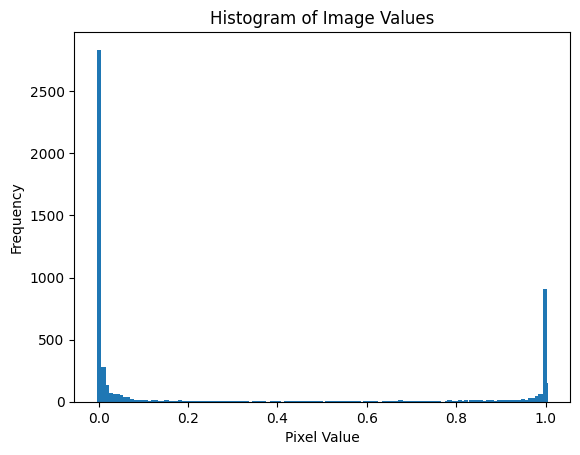

In [ ]:
# Use the histogram to show data distributuion
import matplotlib.pyplot as plt

# Convert histogram values to a Python list
histogram_list = histogram_values.getInfo()

# Extract the bucket boundaries and counts
bucket_boundaries = histogram_list['bucketMeans']
bucket_counts = histogram_list['histogram']

# Plot the histogram
plt.bar(bucket_boundaries, bucket_counts, width=np.diff(bucket_boundaries)[0])
plt.title('Histogram of Image Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Break values
values_array

array([0.00109618, 0.33406412, 0.66703206, 1.        ])

### On-the-Fly Visualizations

In [ ]:
Map.addLayer(max_water_poly, {},'Maximum Water Extent')
Map.centerObject(aoi, zoom = 16)
Map

Map(center=[45.45158995513827, -75.66957774036722], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
Map.addLayer(min_water_poly, {},'Minimum Water Extent')
Map

Map(center=[45.45158995513827, -75.66957774036722], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
Map.addLayer(SAR_WaterProbability, {'min':0, 'max':1,'palette': ['252525','00FFC5']},'SAR_ProbabilityRaster')
Map

Map(center=[45.45158995513827, -75.66957774036722], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
Map.addLayer(dw_water, {'min':0, 'max':1,'palette': ['252525','00FFC5']},'DW_ProbabilityRaster')
Map

Map(center=[45.45158995513827, -75.66957774036722], controls=(WidgetControl(options=['position', 'transparent_…

### Export Results
(Training Data, Probability Raster, Max/Min Water Polygons)

In [ ]:
# Name of the Hydro Reservoir
hydro_reservoir_name = 'McKay'
# Name of the folder you want to export to (a new folder will be created with this name if none exists)
GDrive_FolderName = 'Demo'
GEE_AssetDirectory = 'projects/ee-karloslao/assets/'

TaskDescription_Probability = str(hydro_reservoir_name)+'_ProbailityMap'

### Export training data as csv or shp
#Export_TrainingCSV = ee.batch.Export.table.toDrive(collection=training_data, folder=GDrive_FolderName, description=str(hydro_reservoir_name)+'TraininigData', fileFormat='SHP')  # or fileFormat= 'SHP'
#Export_TrainingCSV.start()

### Export training data as GEE asset
#Export_TrainingAsset = ee.batch.Export.table.toAsset(collection=training_data, description=str(hydro_reservoir_name)+'TraininigData', assetId=GEE_AssetDirectory+str(hydro_reservoir_name)+'_TrainingData')
#Export_TrainingAsset.start()

### Export the Sentinel-2 Probability Map (Multispectral)
#ExportDW_ProbailityRaster = ee.batch.Export.image.toDrive(image=dw_water,region = aoi_buff.geometry(),folder=GDrive_FolderName, description= str(TaskDescription_Probability)+'Sentinel2', fileFormat='GeoTIFF',scale=10, maxPixels=1e13)
#ExportDW_ProbailityRaster.start()

